# Lab/ Audio/ Audio Summary Generation

Auteur: Geoffroy Peeters 

Last update: 2021/11/24

## Introduction

The goal of this lab is to create a system that allows the automatic generation of an audio summary of a music track from the analysis of its adio content.

- the **input** of the system is an audio file (.wav) of a music track
- the **output** of the system is another audio file (.wav) that summarizes the content of the input in ``summary_duration_sec`` seconds.

The method we will use is the "summary score" proposed by [Cooper and Foote, ISMIR 2002].
The difference with the original paper (which uses MFCCs as audio features) is the use of Chroma/PCP as audio features.

You goal will be to fill in the part between ### START CODE HERE ### and ### END CODE HERE ### to complete the system.

The system is splitted into the following steps:

- 1) read an audio file
- 2) compute observations from the audio file at each time (a.k.a. audio features or hand-crafted features). We will use the Chroma/PCP as audio features.
    - 2a) we first need to compute the Short-Time-Fourier-Transform (spectrogram)
    - 2b) create a set of filters that allows to map the STFT to the Chroma/PCP space
    - 2c) use these filters to map the STFT to the Chroma/PCP space
- 3) compute the Self-Similarity-Matrix of the Chroma-gram/PCP-gram
- 4) compute the "summary score" of the SSM and chooses its maximum value as starting point of the audio summary
- 5) write an audio file


We will apply the method to the track "Shivers" by Ed Sheeran 

<img src="https://upload.wikimedia.org/wikipedia/en/b/b0/Ed_Sheeran_-_Shivers.png"  width=200 height=200 />


# Elèves : DESVALLEES Henri, LALAY Louis

# Packages

We first import the set of necessay packages

In [170]:
import numpy as np
import scipy.io.wavfile
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import sys
import tpt_tools
%matplotlib inline

from IPython.display import Latex
do_student = True

# Read the audio file

In [171]:
# audioFile, start_sec, stop_sec, do_post_processing = './_audio/audio_gammepno.wav', 0, 13, False
audioFile, start_sec, stop_sec, do_post_processing = './_audio/audio_ed_22m.wav', 8, 3*60+47, True

sr_hz, audio_v = scipy.io.wavfile.read(audioFile)
audio_v = audio_v[start_sec*sr_hz:stop_sec*sr_hz]
print('sr_hz is {}'.format(sr_hz))
print('size of audio_v is {}'.format(audio_v.size))

sr_hz is 22050
size of audio_v is 4828950


# Compute Chroma-gram/PCP-gram from the audio signal

## Define the parameters of the system

In [172]:
# --- STFT window duration
L_sec = 0.2
# --- STFT hop-size
STEP_sec = 0.2/3

## Compute Short Time Fourier Transform

We first perform the short term analysis using the succession over time of short term DFT  (a.k.a. Short Time Fourier Transform).
We do this using a blackman analysis window of duration 0.2s and hop size 0.2/3s.

The conversion from seconds to samples is
- ``L_n=round(0.2 * sr_hz)`` et
- ``STEP_n=round(0.2/3 * sr_hz)``

in which sr_hz is the sampling rate (which depends on the audio file).

The DFT size $N_{fft}$ should be larger or equal to the window duration $L_n$. 
It should be a power of 2 in order to be able to use the Fast Fourier Transform algorithm (FFT). 
We will use a zero-padding factor of 4 for $N_{fft}$ which means we will take 4 times the value of $N_{fft}$ which is the first power 2 larger than $L_n$.
This zero-padding will help us creating the chroma filters for the lowest frequencies.

In [173]:
# --- Convert values from seconds (_sec) to samples (_n)
L_n = int(np.round(L_sec * sr_hz))
STEP_n = int(np.round(STEP_sec*sr_hz))
# --- Compute the DFT size using zero-padding
Nfft = 4*tpt_tools.nextpow2(L_n)

At each frame, we 
- window the signal
- compute its DFT
- store the results in a matrix

In [174]:
def F_getSTFTFromAudio(audio_v, sr_hz, L_n, STEP_n, Nfft):
    """
    inputs:
        - audio_v: audio signal
        - sr_hz: sampling rate
        - L_n: window duration
        - STEP_n: hop size
        - Nfft: fft size
    outputs:
        - STFT_ampl_m (Nfft/2+1, nbFrame)
        - STFT_freq_hz_v (Nfft/2+1, )
        - STFT_time_sec_v (nbFrame, )
    """
    
    if do_student:
        ### START CODE HERE ###
        audio_len = len(audio_v)
        n_step = (audio_len - L_n) // STEP_n
        STFT_ampl_m = np.zeros((Nfft//2+1, n_step))
        for k in range(n_step):
            STFT_ampl_m[:,k] = np.abs(np.fft.fft(audio_v[k*STEP_n:k*STEP_n+L_n], Nfft)[:Nfft//2+1])
        STFT_freq_hz_v = np.linspace(0, sr_hz/2, Nfft//2+1)
        STFT_time_sec_v = np.linspace(0, audio_len/sr_hz, n_step)

        ### END CODE HERE ###
    
    # +++++++++++++++++++++++++++++++
    plt.figure(figsize=(10, 6))
    tpt_tools.F_plot2(np.sqrt(STFT_ampl_m), STFT_freq_hz_v, STFT_time_sec_v, 'Frequency [Hz]', 'Time [sec]')
    plt.ylim((0,2000))
    # +++++++++++++++++++++++++++++++
    
    return STFT_ampl_m, STFT_freq_hz_v, STFT_time_sec_v

32768
(16385, 3282)
(16385,)
(3282,)


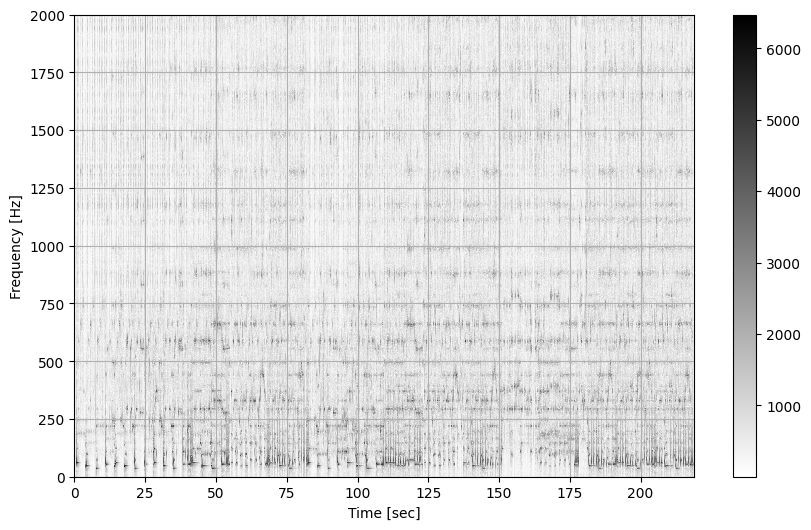

In [175]:
STFT_ampl_m, STFT_freq_hz_v, STFT_time_sec_v = F_getSTFTFromAudio(audio_v, sr_hz, L_n, STEP_n, Nfft)

print(Nfft)
print(STFT_ampl_m.shape)
print(STFT_freq_hz_v.shape)
print(STFT_time_sec_v.shape)

### Test the function

When ```audioFile = './_audio/audio_gammepno.wav'```

you should obtain the following values

```(65536)
(32769, 192)
(32769,)
(192,)
```

you should obtain the following figure
<img src="./_images/TPstruct_01.png" width=400/>

## Create the matrix containing the Chroma/PCP filters

There is 12 Chromas (or PCP-Pitch Class Profile). 

For each chroma ```c```, we will create a specific filter that perform the mapping between the values of the DFT and this specific chroma.

We denote by ```n```, the semi-tone-pitches (or midi notes). For example ```n=69``` is A-4 or 440Hz.
The chroma ```c``` corresponding to a given semi-note ```n``` is given by ```c = mod(n, 12)```.
The chroma ```c``` should therefore represents the energy existing in the DFT at all semi-pitches ```n``` such that ```c = mod(n, 12)```.

For each of these ```n```, we will create a band-pass filter centered on $n$ and extending on the left to ```n-1``` and the right to ```n+1```.

Each band-pass filter is normalized such that it sums to 1.

To create the filters we can use the following formula which maps the DFT frequencies (in Hz) ```STFT_freq_hz_v```to the corresponding midi notes ```STFT_freq_midi_v```: ```STFT_freq_midi_v = 12 * log2(STFT_freq_hz_v / 440)+69```.

The shape of the filter will be defined by the following formula:
$$H = \frac{1}{2} \tanh(\pi (1-2x))+\frac{1}{2}$$ 
in which $x$ represents the absolute value of the distance between ```n``` and ```STFT_freq_midi_v```: ```x = abs(n - STFT_freq_midi_v)```.

We will only consider the MIDI notes from 36 to 119: ```n=36 ... 119```.

The 12 chroma filters are stored in a matrix ```(12, Nfft/2+1)```, i.e. one filter per row.

In [176]:
def midi_to_f(p):
    return 440 * np.power(2, (p - 69) / 12)
def f_to_midi(f):
    return 12*np.log2(f/440)+69
def H(x):
    return 0.5 * np.tanh(np.pi * (1 - 2 * x)) + 0.5
def distance(p, f):
    return np.abs(p - f)
def get_chroma(n):
    return (n)%12

def F_getChromaFiltre(STFT_freq_hz_v, startMidi=36, endMidi=119):
    """
    inputs:
        - STFT_freq_hz_v (N/2+1): frequency axis of the DFT in Hz
        - startMidi: starting midi note (int)
        - endMidi: ending midi note (int)
    outputs:
        - chromaFiltre_m (12, N/2+1)
        - midi_v (nbMidi)
    """

    if do_student:
        ### START CODE HERE ###
        STFT_freq_midi_v = f_to_midi(STFT_freq_hz_v)
        chromaFiltre_m = np.zeros((12, len(STFT_freq_hz_v)))
        for p in range(startMidi, endMidi+1):
            # Calcul du filtre pour la note
            x = distance(p , STFT_freq_midi_v)
            # Détermination du chroma
            c = get_chroma(p)
            # Adition au tableau de filtre pour le chroma correspondant
            chromaFiltre_m[c,:] += H(x)/np.sum(H(x))
        midi_v = np.arange(startMidi, endMidi+1)
        ### END CODE HERE ###

    # +++++++++++++++++++++++++++++++
    plt.figure(figsize=(10, 4))
    tpt_tools.F_plot1(STFT_freq_hz_v, chromaFiltre_m[8, :], "Frequency [Hz]", "Value")
    plt.xlim((0, 2000))
    # +++++++++++++++++++++++++++++++

    return chromaFiltre_m, midi_v

(12, 16385)
(84,)


/tmp/ipykernel_29831/468665380.py:4: RuntimeWarning: divide by zero encountered in log2
  return 12*np.log2(f/440)+69


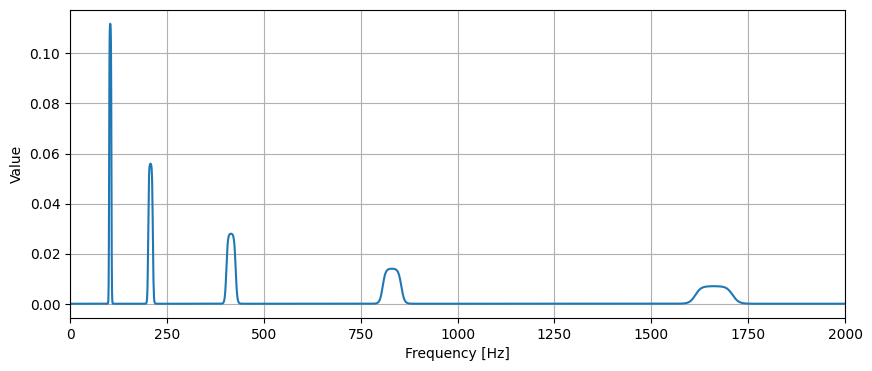

In [177]:
chromaFiltre_m, midi_v = F_getChromaFiltre(STFT_freq_hz_v)

print(chromaFiltre_m.shape)
print(midi_v.shape)

### Test the function

 You should obtain the following values
 
 ``(12, 32769)
(84,)``

You should obtain the following figure
<img src="./_images/TPstruct_02.png" width=400/>

### Display all the filters as a matrix

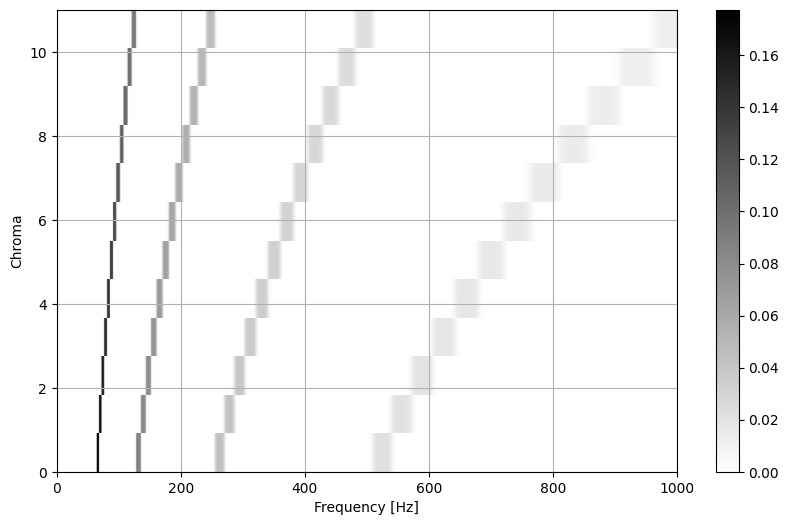

In [178]:
plt.figure(figsize=(10, 6))
tpt_tools.F_plot2(chromaFiltre_m, np.arange(0, 12), STFT_freq_hz_v, 'Chroma', 'Frequency [Hz]')
plt.xlim((0,1000));

You should obtain the following figure
<img src="./_images/TPstruct_03.png" width=400/>

## Compute the Chromagram

To obtain the Chroma-gram/PCP-gram, we simply multiply (matrix multiplication) the Chroma/PCP matrix with the STFT matrix:
(12, N/2+1) * (N/2+1, nbFrame) = (12, nbFrame). 

The output of this is a matrix in which the rows represent the 12 values of the chroma and the column the successive time frames.



(12, 16385)
(16385, 3282)
(12, 3282)


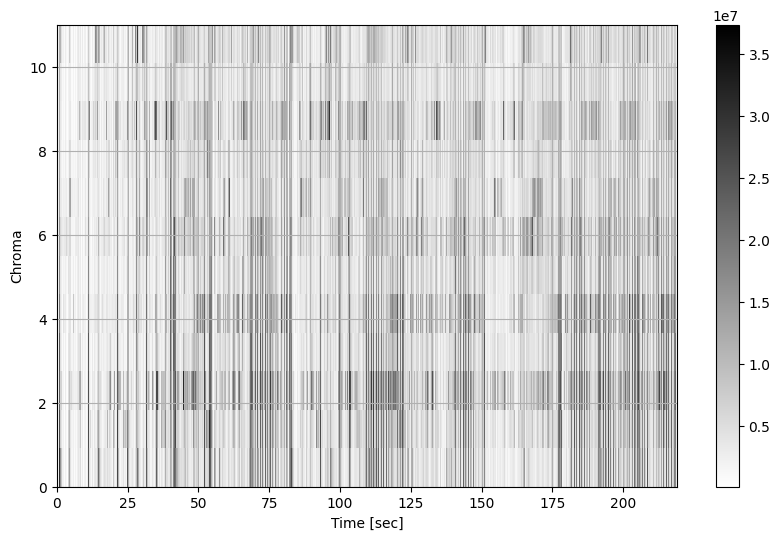

In [179]:
chromaGram_m = np.dot(chromaFiltre_m, STFT_ampl_m)

print(chromaFiltre_m.shape)
print(STFT_ampl_m.shape)
print(chromaGram_m.shape)

plt.figure(figsize=(10, 6))
tpt_tools.F_plot2(chromaGram_m, np.arange(0, 12), STFT_time_sec_v, 'Chroma', 'Time [sec]')

### Test the function

When ```audioFile = './_audio/audio_gammepno.wav'```, 

you should obtain the following values

```(12, 32769)
(32769, 192)
(12, 192)
```

you should obtain the following figure
<img src="./_images/TPstruct_04.png" width=400/>

### Post-processing

To make the visualisation/detection of the structure easier we apply some post-processing. We first smooth the chromagram over time.

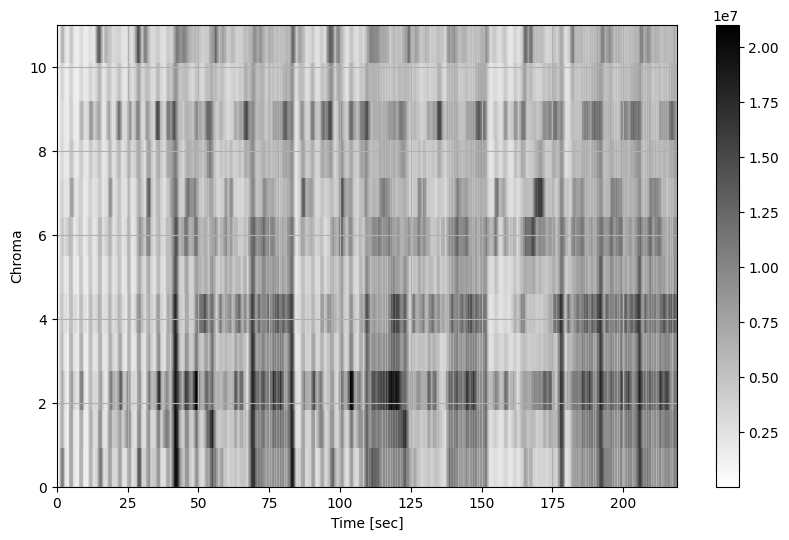

In [180]:
if do_post_processing:
    L = 21
    chromaGramSmooth_m = np.zeros(chromaGram_m.shape)
    for dim in range(12):
        chromaGramSmooth_m[dim,:] = scipy.signal.lfilter(np.ones(L)/L, 1, chromaGram_m[dim,:])
    chromaGram_m = chromaGramSmooth_m
    
    plt.figure(figsize=(10, 6))
    tpt_tools.F_plot2(chromaGram_m, np.arange(0, 12), STFT_time_sec_v, 'Chroma', 'Time [sec]')  

# Compute the Self-Similarity-Matrix (time,time) using of the Chroma-gram/PCP-gram

We now compute the Self-Similarity-Matrix (SSM) using the Chroma-gram/PCP-gram.
An entry $(i,j)$ in the SSM represent the similarity between time $ t_i $ and time $t_j$.

To compute this similarity, we will use the ```cosine distance``` between the chroma vector at time $t_i$ and the one at $t_j$.

If we note $\underline{x}$ the vector at time $t_i$ and $\underline{y}$ the vector at time $t_j$, the ```cosine distance``` between them is defined as 

$$dist(\underline{x},\underline{y})=\frac{\underline{x} \cdot \underline{y}}{||\underline{x}|| \;||\underline{y}||}$$

In [181]:
def cosine_distance(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


def F_getSsmTT(data_m):
    """
    inputs:
        - data_m (nbDim, nbFrame)
    outputs:
        - ssmTT_m (nbFrame, nbFrame)
    """

    if do_student:
        ### START CODE HERE ###
        ssmTT_m = np.zeros((data_m.shape[1], data_m.shape[1]))
        for i, x in enumerate(data_m.T):
            for j, y in enumerate(data_m.T):
                ssmTT_m[i, j] = cosine_distance(x, y)
        ### END CODE HERE ###

    return ssmTT_m

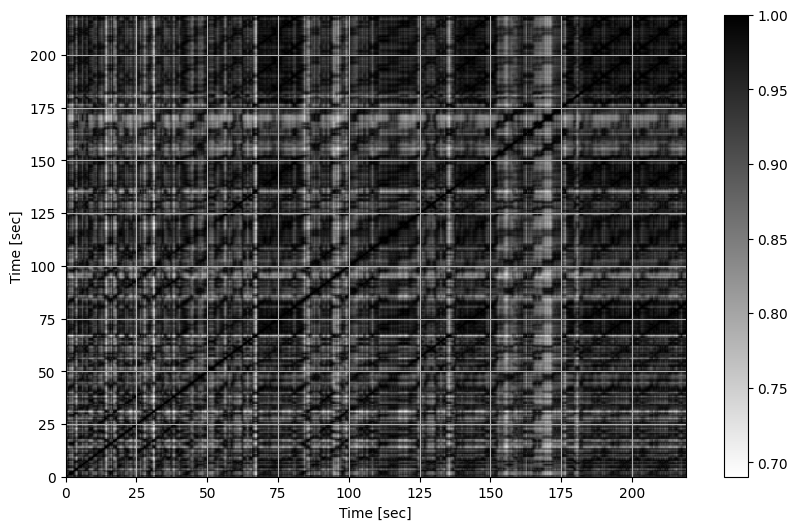

In [182]:
ssmTT_m = F_getSsmTT(chromaGram_m)

# --- Display the matrix
plt.figure(figsize=(10, 6))
tpt_tools.F_plot2(ssmTT_m, STFT_time_sec_v, STFT_time_sec_v, 'Time [sec]', 'Time [sec]')

### Test the function

When ```audioFile = './_audio/audio_gammepno.wav'```, 

you should obtain the following figure

<img src="./_images/TPstruct_05.png" width=400/>

### Post-processing

To make the visualisation/detection of the structure easier we apply some post-processing. 
We apply a strong threshold to the SSM to only let the high values visible.

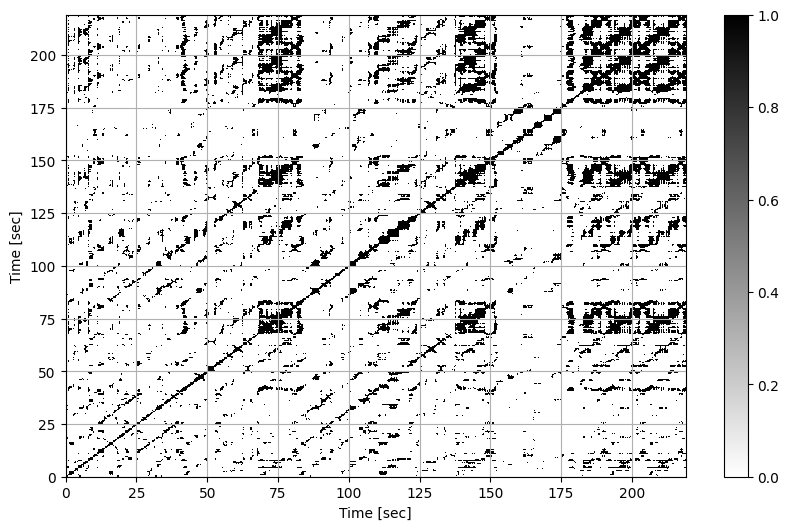

In [183]:
if do_post_processing:
    ssmTT_m[ssmTT_m<0.98]=0

    # --- Display the matrix
    plt.figure(figsize=(10, 6))
    tpt_tools.F_plot2(ssmTT_m, STFT_time_sec_v, STFT_time_sec_v, 'Time [sec]', 'Time [sec]')

# Get the best position for the start of the summary

To get the best position for the start of the summary ``startPos_frame``, we will compute the ``summary_score_v`` of the SSM. 

We then choose its maximum value as the start of our audio summary.
Indeed, this maximum value represent the best starting point of a segment of duration ``summary_duration_sec`` such that this segment best represent (is the most similar to) the whole content of the music track.

Computation of the ``summary_score_v`` as proposed by [Cooper, Foote, 2002]:
- For each time ``q`` (row q in the matrix), the summary score is computed as the sum over the column of the matrix for this specific row. It represents the similarity between the specific time ``q`` and the rest of the music track.
- For a segment starting at ``q`` and of duration ``L``, the summary score is computed as the sum over the part of the columns between ``q`` and ``q+L``. It represents the similarity between the segment ``[q,q+L]`` and the rest of the music track.
- ``L`` is imposed as the length of the audio summary (``summary_duration_sec`` in our case).

Since we look for the best summary of duration ``summary_duration_sec``, we look for the value of ``q`` which maximizes the summary score.

In [184]:
def F_getSummaryScore(ssmTT_m, summary_duration_frame):
    """
    inputs:
        - ssmTT_m (nbFrame, nbFrame)
        - summary_duration_frame
    outputs:
        - startPos_frame
        - summary_score_v (nbFrame)
    """
    
    if do_student:
        ### START CODE HERE ###
        N = len(ssmTT_m)
        L = summary_duration_frame
        summary_score_v = np.zeros(N)
        for q in range(N - L):
            r = q + L
            R = 0
            for m in range(q, r):
                for n in range(r, N):
                    R+=ssmTT_m[m,n]
            summary_score_v[q] = R
        startPos_frame = np.argmax(summary_score_v)
        ### END CODE HERE ###
    
    return startPos_frame, summary_score_v

#### Display the summary length for various duration of summary

In [197]:
# --- define the duration of the summary in seconds
summary_duration_sec = 25

### Test the function

In [198]:
# --- convert it to number of frames
summary_duration_frame, summary_duration_n = int(summary_duration_sec/STEP_sec), int(summary_duration_sec*sr_hz)
print("Duration in sec:{} in samples:{} in frames:{}".format(summary_duration_sec, summary_duration_n, summary_duration_frame))

startPos_frame, summary_score_v = F_getSummaryScore(ssmTT_m, summary_duration_frame)
startPos_sec, startPos_n = startPos_frame*STEP_sec, int(startPos_frame*STEP_sec*sr_hz)

Duration in sec:25 in samples:551250 in frames:375


#### Display the resuting score function and estimated starting point of the audio summary

Start sec:58.3, samples:1284780.0 frames:874


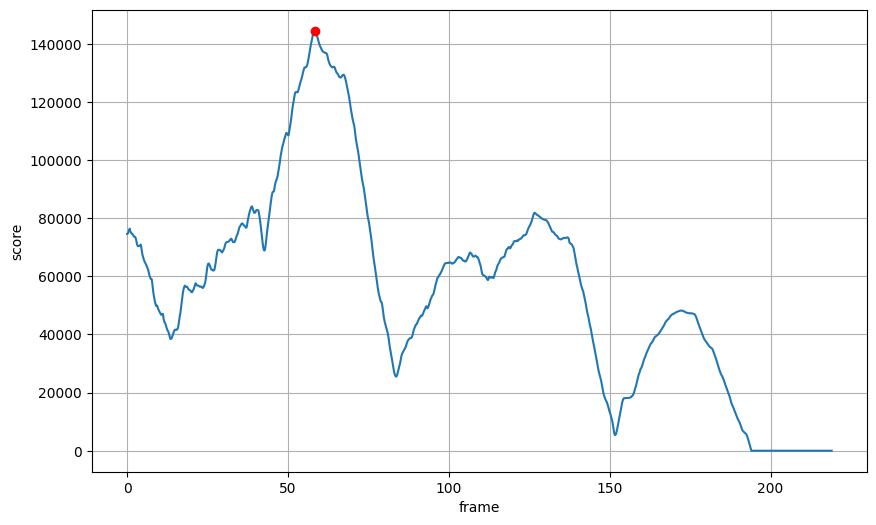

In [202]:
plt.figure(figsize=(10, 6))
tpt_tools.F_plot1(STFT_time_sec_v, summary_score_v, 'frame', 'score')
plt.plot(startPos_sec, summary_score_v[startPos_frame], 'ro')
print(f"Start sec:{startPos_sec:.1f}, samples:{startPos_n:.1f} frames:{startPos_frame}")

#### Display the selected segment over the Self-Similarity-Matrix

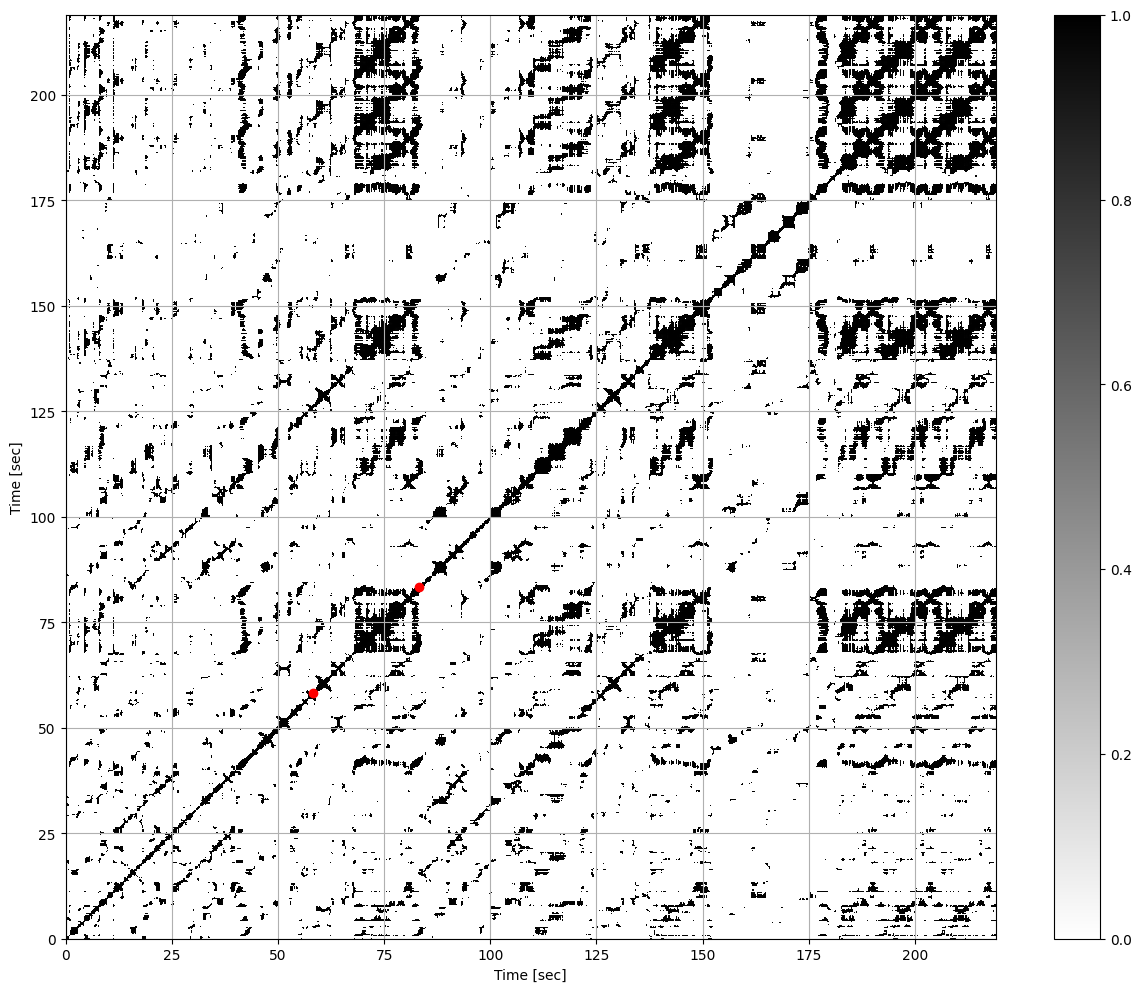

In [200]:
plt.figure(figsize=(15, 12))
tpt_tools.F_plot2(ssmTT_m, STFT_time_sec_v, STFT_time_sec_v, 'Time [sec]', 'Time [sec]')
plt.plot(startPos_sec, startPos_sec, 'ro')
plt.plot(startPos_sec+summary_duration_sec, startPos_sec+summary_duration_sec, 'ro')

# Generate the audio summary

The audio summary is then simply the segment starting at ```startPos``` and of duration ```duration```.

In [201]:
scipy.io.wavfile.write(audioFile.replace('.wav', '-summary.wav'), sr_hz, audio_v[startPos_n:startPos_n+summary_duration_n])